In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

np.random.seed(42)

# Data Load & Data Pre-processing

In [2]:
X_DATA_PATH = "./data/cropped/"
Y_DATA_PATH = "./data/resized/"

x_data_path_list = os.listdir(X_DATA_PATH)
y_data_path_list = os.listdir(Y_DATA_PATH)

X, y = list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))

Y data loading...: 100%|██████████| 1020/1020 [00:00<00:00, 1945.11it/s]


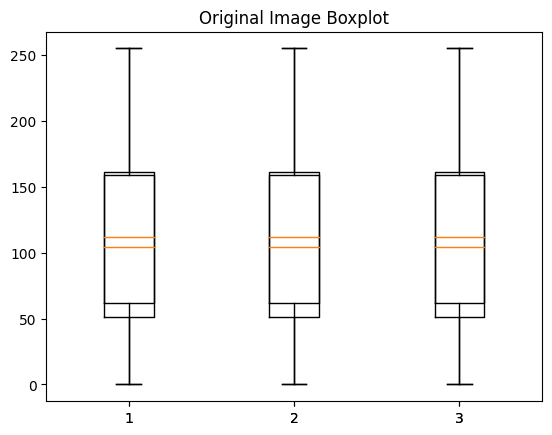

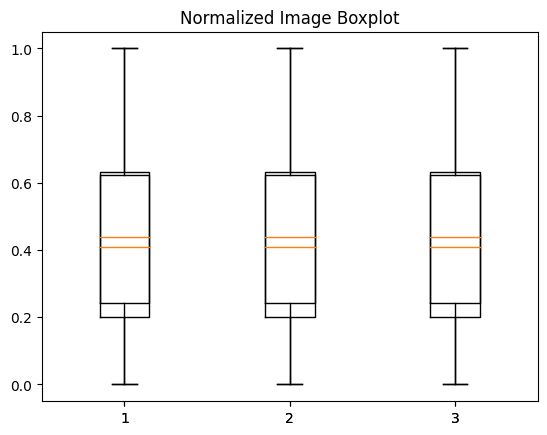

In [3]:
X = np.array(X)
y = np.array(y)

plt.title("Original Image Boxplot")
plt.boxplot(X.reshape(-1, 3))
plt.boxplot(y.reshape(-1, 3))
plt.show()

# Pre-processing
X = X.astype('float32') / 255.
y = y.astype('float32') / 255.

plt.title("Normalized Image Boxplot")
plt.boxplot(X.reshape(-1, 3))
plt.boxplot(y.reshape(-1, 3))
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"""X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_test shape: {X_test.shape}
y_test shape: {y_test.shape}""")

ValueError: Found input variables with inconsistent numbers of samples: [1000, 1020]

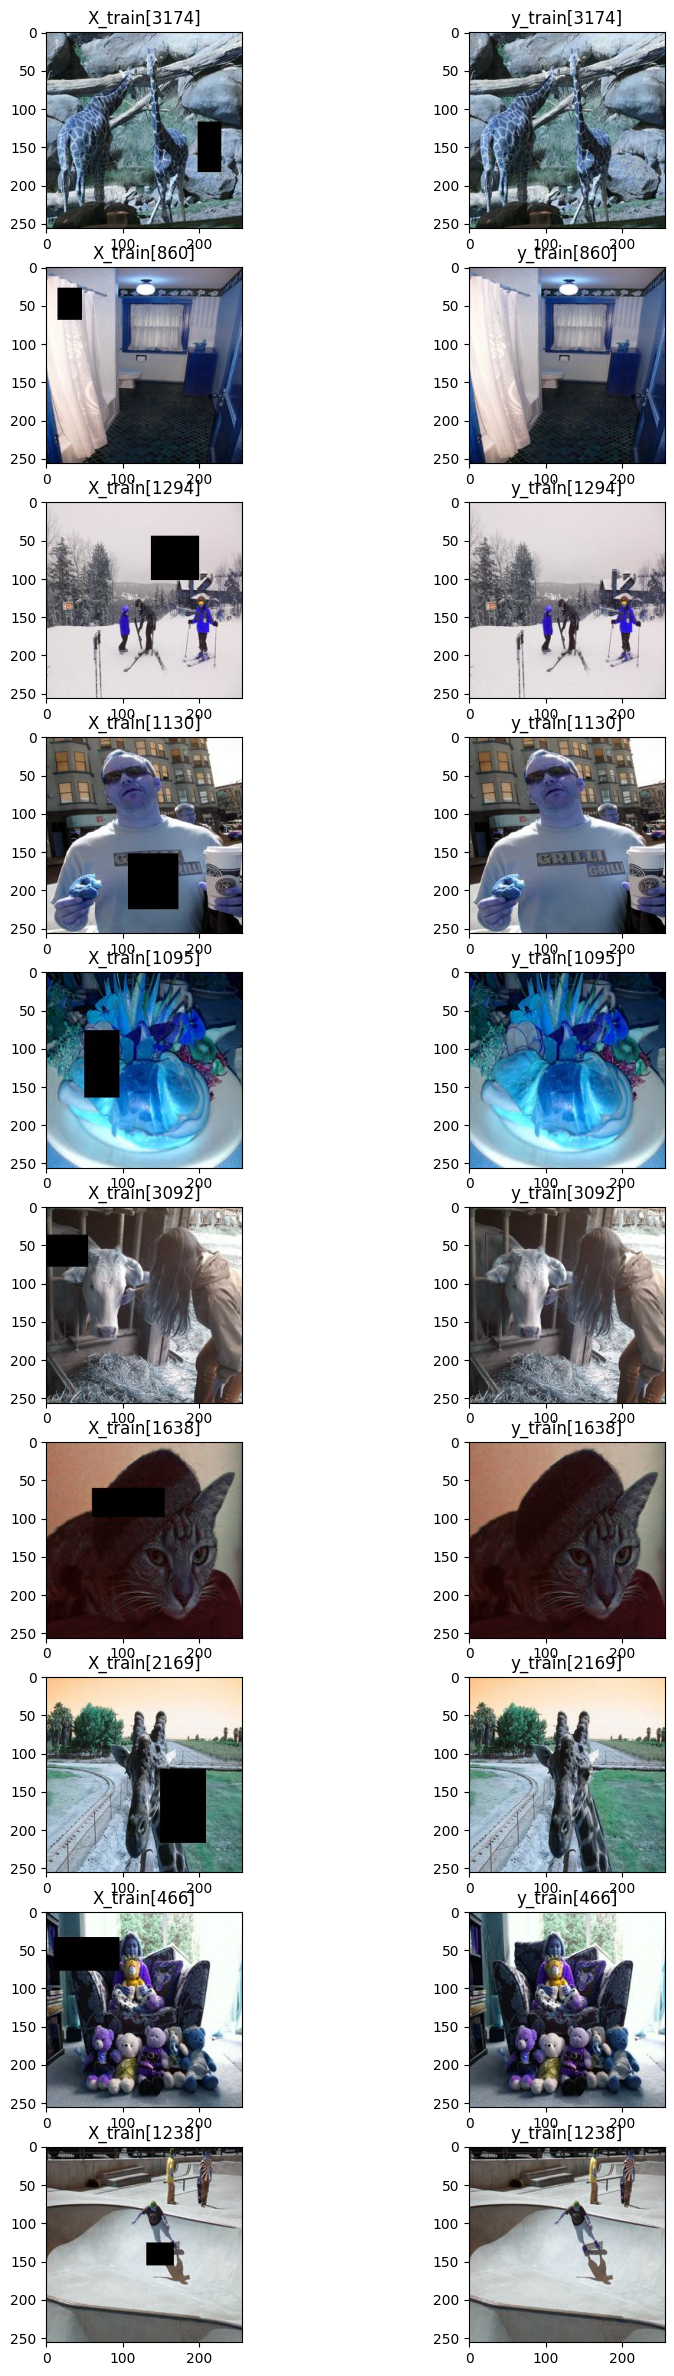

In [ ]:
randlist = np.random.randint(0, X_train.shape[0], 10)

ax, fig = plt.subplots(10, 2, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_train[{j}]")
    fig[i][1].title.set_text(f"y_train[{j}]")
    fig[i][0].imshow(X_train[j])
    fig[i][1].imshow(y_train[j])
plt.show()

# Modeling

In [6]:
outDir = './checkpoint_unet/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{epoch}-{val_loss:.8f}.h5'
def get_callbacks(patience = 50):
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_loss', save_best_only=True, period = 1)
    callbacks = [model_checkpoint]
    return callbacks

callback = get_callbacks()

In [7]:
# Import U-Net
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [8]:
model = unet(input_size=(256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)              

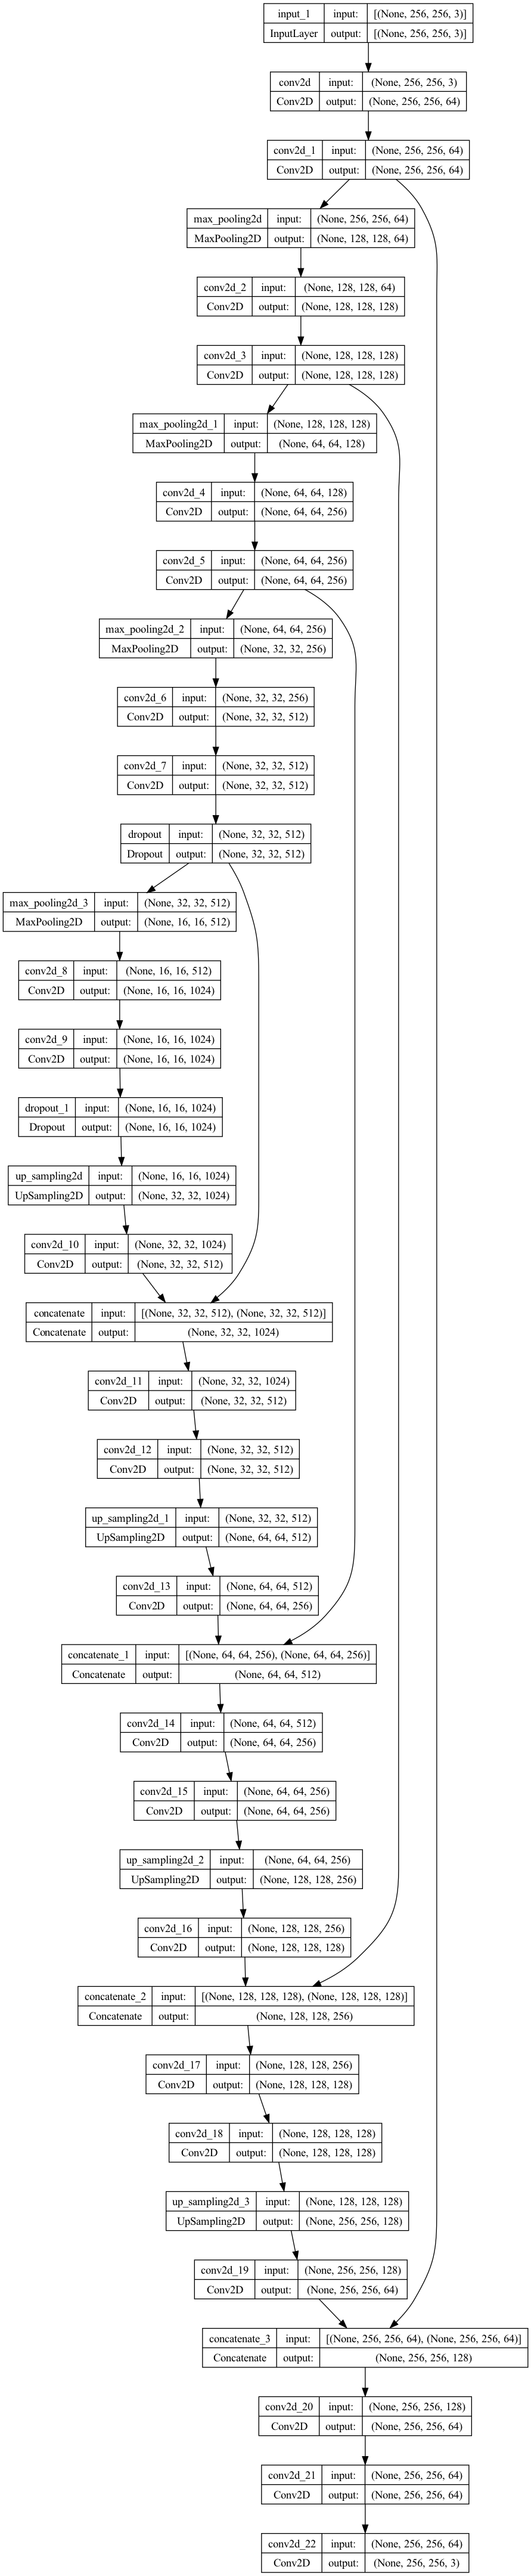

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

# Training & Validation

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16,
    verbose=1,
)

Epoch 1/10
219/219 [==============================] - 1064s 5s/step - loss: 0.7928 - accuracy: 0.6771 - val_loss: 0.5174 - val_accuracy: 0.8082
Epoch 2/10
219/219 [==============================] - 1073s 5s/step - loss: 0.5184 - accuracy: 0.8296 - val_loss: 0.5155 - val_accuracy: 0.8325
Epoch 3/10
219/219 [==============================] - 1104s 5s/step - loss: 0.5276 - accuracy: 0.8066 - val_loss: 0.5161 - val_accuracy: 0.8295
Epoch 4/10
219/219 [==============================] - 1093s 5s/step - loss: 0.5166 - accuracy: 0.8459 - val_loss: 0.5143 - val_accuracy: 0.8445
Epoch 5/10
219/219 [==============================] - 1106s 5s/step - loss: 0.5157 - accuracy: 0.8511 - val_loss: 0.5135 - val_accuracy: 0.8425
Epoch 6/10
219/219 [==============================] - 1109s 5s/step - loss: 0.5149 - accuracy: 0.8571 - val_loss: 0.5134 - val_accuracy: 0.8331
Epoch 7/10
219/219 [==============================] - 1109s 5s/step - loss: 0.5148 - accuracy: 0.8591 - val_loss: 0.5133 - val_accuracy:

# Model Train Result

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

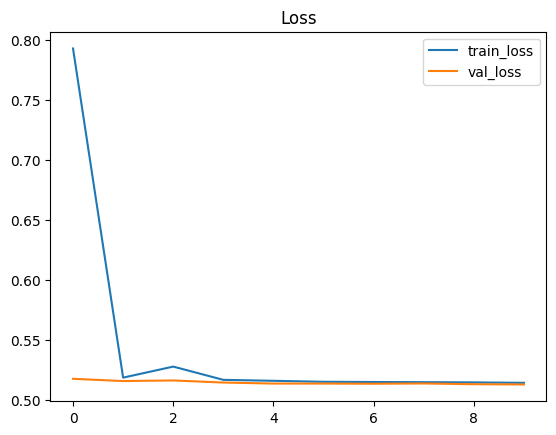

In [12]:
plt.title("Loss")
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

# Evaluation

47/47 [==============================] - 118s 2s/step


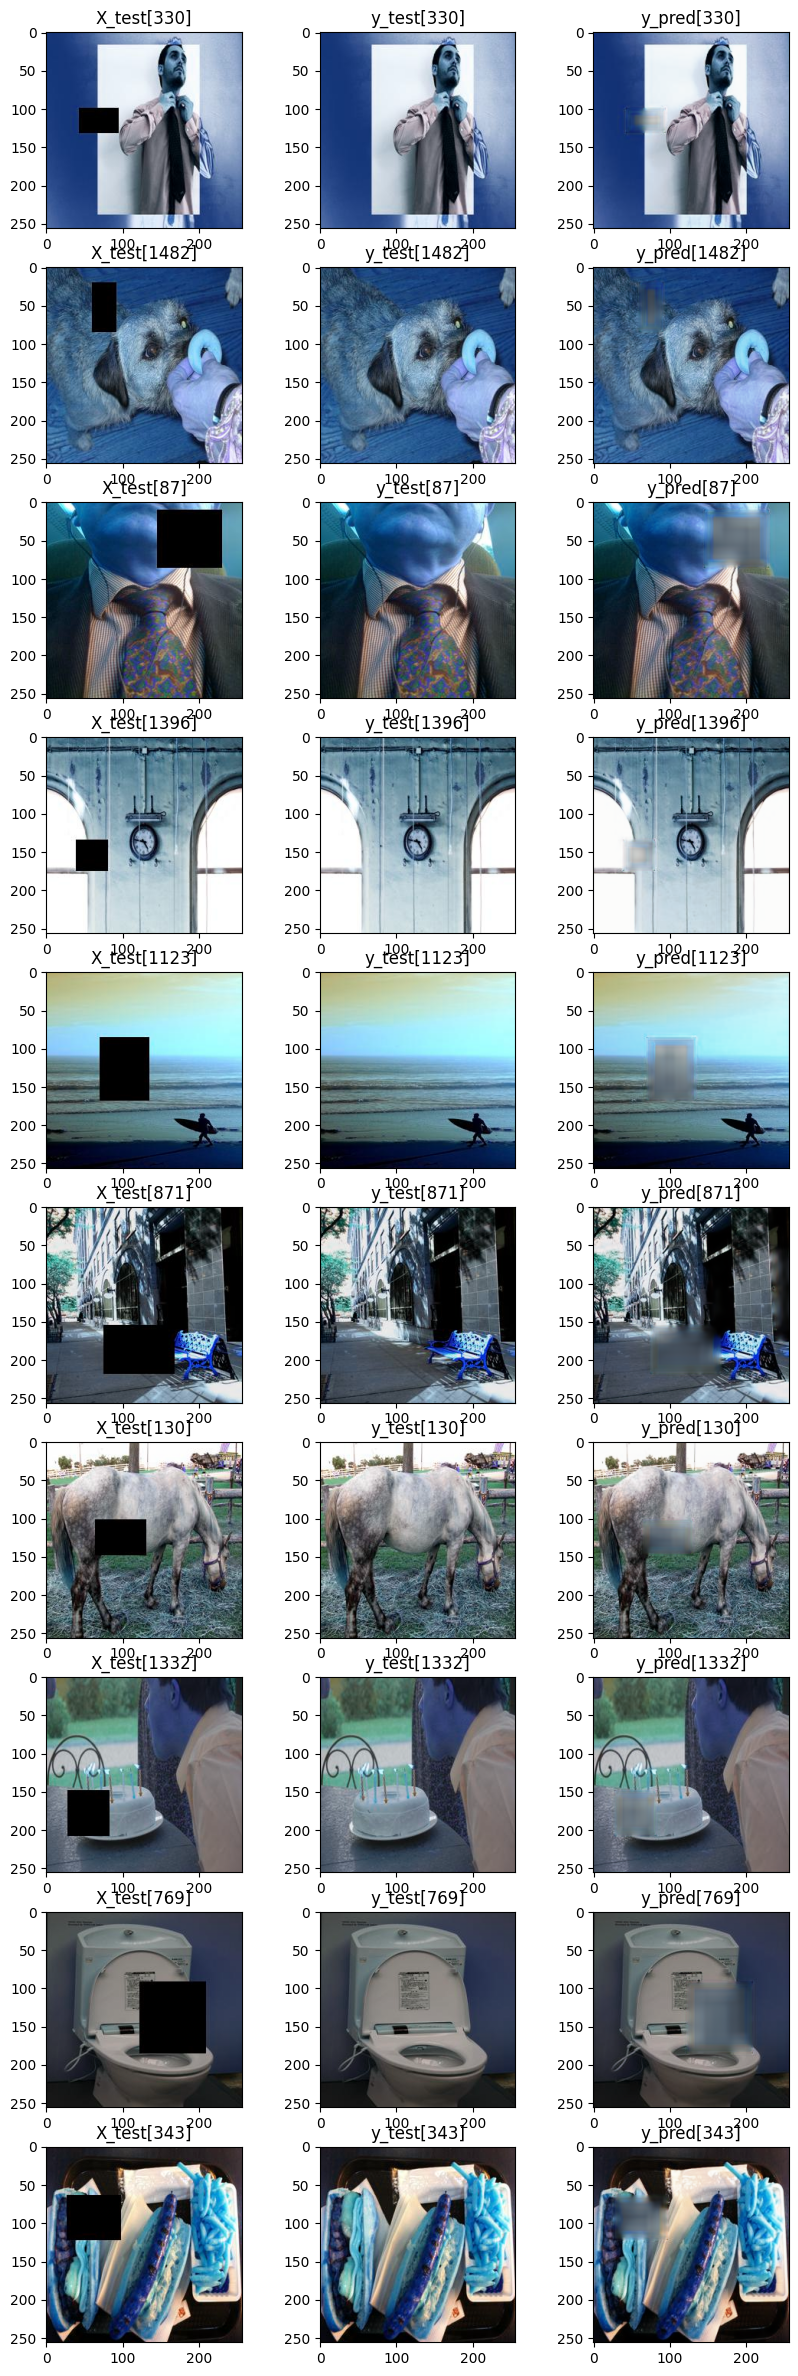

In [13]:
y_pred = model.predict(X_test)

randlist = np.random.randint(0, X_test.shape[0], 10)

ax, fig = plt.subplots(10, 3, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_test[{j}]")
    fig[i][1].title.set_text(f"y_test[{j}]")
    fig[i][2].title.set_text(f"y_pred[{j}]")
    fig[i][0].imshow(X_test[j])
    fig[i][1].imshow(y_test[j])
    fig[i][2].imshow(y_pred[j])